In [23]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

In [24]:
#number of individual 
N = 12
#PVC total count 
t = np.array([11, 11, 17, 22, 9, 6, 5, 14, 9, 7, 22, 51])

#before drugs 
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])

#after drugs 
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])

heats = np.vstack((t,x,y))
hearts = heats.T
hearts

array([[11,  6,  5],
       [11,  9,  2],
       [17, 17,  0],
       [22, 22,  0],
       [ 9,  7,  2],
       [ 6,  5,  1],
       [ 5,  5,  0],
       [14, 14,  0],
       [ 9,  9,  0],
       [ 7,  7,  0],
       [22,  9, 13],
       [51, 51,  0]])

In [25]:
def Hearts_gibbs(nchain, sigma_delta, sigma_alpha, tau, sigma, data_hearts, thinning_step = 1, nb_burn = 0):
    chain = np.zeros((nchain+1,2))  #première colonne les alpha, 2nde colonne les delta + initialisation à (0,0)

    index_thinning = np.arange(start=0, stop=nchain+1 - nb_burn, step=thinning_step) # Pour élaguer en fin d'algo

    T = data_hearts[:,0]  # X + Y (total number of PVC)
    X = data_hearts[:,1]  # Nb de PVC Avant traitement
    Y = data_hearts[:,2]  # Nb de PVC après traitement

    tx_acc = 0  # Init du taux d'acceptation

    for i in range (nchain):
        
        vect_prop = chain[i,:]  # On utilise un vecteur intermediaire pour ne pas modifier la chaîne directement

        for j in range(2):  #On boucle sur les paramètres d'intérêt

            sd_prop = sigma_alpha*(j==0) + sigma_delta*(j==1)  # Pour déterminer le sd du noyau de prop
            coord_prop = rnd.normal(vect_prop[j],sd_prop)   # Proposition d'un candidat

            if (j==0):  # on modifie alpha
                alpha = vect_prop[0]
                delta = vect_prop[1]
                alpha_prop = coord_prop
                
                top = -alpha_prop**2/(2*sigma) + np.sum(np.log((np.exp(delta)+(1+np.exp(alpha_prop))**(-T))*(Y==0)+np.exp(alpha_prop*Y)*((1+np.exp(alpha_prop))**(-T)*(Y!=0)))) 
                bottom = -alpha**2/(2*sigma) + np.sum(np.log((np.exp(delta)+(1+np.exp(alpha))**(-T))*(Y==0)+np.exp(alpha*Y)*((1+np.exp(alpha))**(-T)*(Y!=0))))
            else: # On modifie delta
                alpha = vect_prop[0]  #si maj du alpha celle-ci a été prise en compte dans le vect_prop
                delta = vect_prop[1]
                delta_prop = coord_prop
                
                top = -delta_prop**2/(2*tau) + np.sum(np.log(((1+np.exp(delta_prop))**(-1)*(np.exp(delta_prop)+(1+np.exp(alpha))**(-T)))*(Y==0)+(1+np.exp(delta_prop))**(-1)*(Y!=0))) 
                bottom = -delta**2/(2*tau) + np.sum(np.log(((1+np.exp(delta))**(-1)*(np.exp(delta)+(1+np.exp(alpha))**(-T)))*(Y==0)+(1+np.exp(delta))**(-1)*(Y!=0)))
            

            acc_prob = np.exp(top - bottom)

            if(rnd.uniform()<acc_prob):     # Seulement phase d'acceptation car on a travaillé seulement sur le vecteur intermediaire vect_prop
                vect_prop[j] = coord_prop
                tx_acc +=1
        
        chain[i+1,:] = vect_prop  #On intègre le vect_prop à la chaîne --> Inclue la phase de rejet au final

    chain = chain[np.arange(nb_burn, nchain+1),:]  # Période de burn
    chain = chain[index_thinning,:]   #Elagage de la chaîne

    return(chain, tx_acc/(2*nchain))


In [26]:
tau = 10**4
sigma = 10**4

chain_gibbs, tx_Acc = Hearts_gibbs(11000, 1, 0.5, tau, sigma, hearts, 5, 1000)

In [27]:
tx_Acc

0.5499090909090909

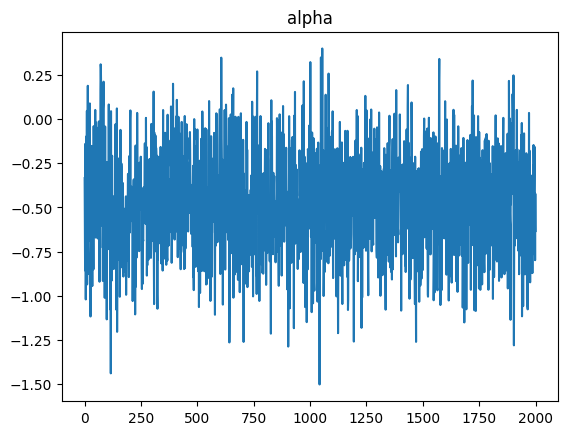

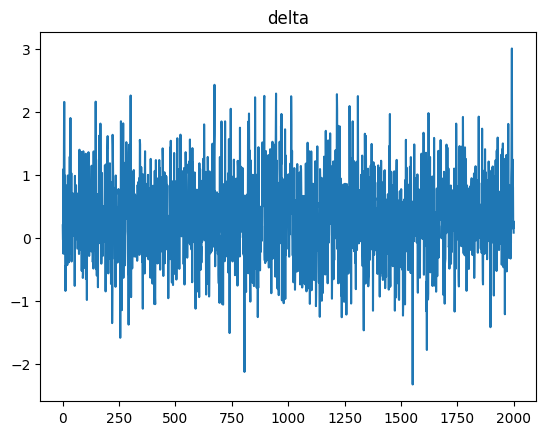

In [28]:
plt.plot(chain_gibbs[:,0])
plt.title("alpha")
plt.show()
plt.plot(chain_gibbs[:,1])
plt.title("delta")
plt.show()

In [29]:
print("mu_alpha : ", round(np.mean(chain_gibbs[:,0]),4))
print("sd_alpha : ", round(np.std(chain_gibbs[:,0]),4))

print("mu_delta : ", round(np.mean(chain_gibbs[:,1]),4))
print("sd_delta : ", round(np.std(chain_gibbs[:,1]),4))

mu_alpha :  -0.486
sd_alpha :  0.2777
mu_delta :  0.3305
sd_delta :  0.6439
